<a href="https://colab.research.google.com/github/pmrmoura/IA-Projeto/blob/main/ProjetoIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TREINAMENTO COM SVM

##Importações e Leitura

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report)

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

### Carregar o Dataset

In [ ]:
print("1. CARREGANDO DADOS...")

# Ajuste conforme o nome do seu arquivo CSV
df = pd.read_csv('heart_disease_uci.csv')
print("\nPrimeiras linhas do dataset:")
print(df.head())

1. CARREGANDO DADOS...

Primeiras linhas do dataset:
   id  age     sex    dataset               cp  trestbps   chol    fbs  \
0   1   63    Male  Cleveland   typical angina     145.0  233.0   True   
1   2   67    Male  Cleveland     asymptomatic     160.0  286.0  False   
2   3   67    Male  Cleveland     asymptomatic     120.0  229.0  False   
3   4   37    Male  Cleveland      non-anginal     130.0  250.0  False   
4   5   41  Female  Cleveland  atypical angina     130.0  204.0  False   

          restecg  thalch  exang  oldpeak        slope   ca  \
0  lv hypertrophy   150.0  False      2.3  downsloping  0.0   
1  lv hypertrophy   108.0   True      1.5         flat  3.0   
2  lv hypertrophy   129.0   True      2.6         flat  2.0   
3          normal   187.0  False      3.5  downsloping  0.0   
4  lv hypertrophy   172.0  False      1.4    upsloping  0.0   

                thal  num  
0       fixed defect    0  
1             normal    2  
2  reversable defect    1  
3          

## Análise Básica e Pré-Processamento

###Analise Básica

In [ ]:
print("\nInformações gerais do DataFrame:")
print(df.info())


Informações gerais do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB
None


In [ ]:
dup_count = df.duplicated().sum()
print(f"\nLinhas duplicadas: {dup_count}")
if dup_count > 0:
    df.drop_duplicates(inplace=True)
    print(f"Linhas duplicadas removidas. Novo shape: {df.shape}")


Linhas duplicadas: 0


In [ ]:
print("\nValores ausentes por coluna:")
print(df.isnull().sum())


Valores ausentes por coluna:
id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64


In [ ]:
#  Dropando coluna que não é util para previsão.
if 'dataset' in df.columns:
    print("\nRemovendo coluna 'dataset' (não é relevante para modelagem).")
    df.drop(columns=['dataset'], inplace=True, errors='ignore')


Removendo coluna 'dataset' (não é relevante para modelagem).


###Mapeamento (colunas textuais para númericas)

In [ ]:
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
print("\nColunas categóricas detectadas:", cat_cols if cat_cols else "Nenhuma")


Colunas categóricas detectadas: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']


In [ ]:
if 'sex' in df.columns and df['sex'].dtype == object:
    df['sex'] = df['sex'].map({'Male': 1, 'Female': 0}).fillna(0)

if 'exang' in df.columns and df['exang'].dtype == object:
    df['exang'] = df['exang'].map({'Yes': 1, 'No': 0}).fillna(0)

In [ ]:
#Criação da coluna target

if 'num' in df.columns:
    df['target'] = df['num'].apply(lambda x: 1 if x > 0 else 0)

if 'target' not in df.columns:
    raise ValueError("Coluna 'target' não encontrada ou não foi criada. Verifique se 'num' existe no CSV.")

In [ ]:
#'cp' (chest pain)
# Valores: "typical angina", "asymptomatic", "non-anginal", "atypical angina"
# Mapear para 0,1,2,3:
if 'cp' in cat_cols:
    cp_map = {
        'typical angina': 0,
        'atypical angina': 1,
        'non-anginal': 2,
        'asymptomatic': 3
    }
    df['cp'] = df['cp'].map(cp_map)
    cat_cols.remove('cp')

In [ ]:
#'restecg'
# Valores: "normal", "lv hypertrophy", "ST-T wave abnormality"
if 'restecg' in cat_cols:
    restecg_map = {
        'normal': 0,
        'lv hypertrophy': 1,
        'st-t abnormality': 2
    }
    df['restecg'] = df['restecg'].map(restecg_map)
    cat_cols.remove('restecg')

In [ ]:
if 'fbs' in cat_cols:
    # Observou-se que fbs às vezes é "True"/"False" ou "Yes"/"No"
    # mas, se ela tem muitos NaNs, poderemos remover adiante
    fbs_map = {'TRUE':1, 'FALSE':0, 'Yes':1, 'No':0}
    df['fbs'] = df['fbs'].map(fbs_map)
    # se existirem valores fora do dicionário, viram NaN
    cat_cols.remove('fbs')

In [ ]:
if 'exang' in cat_cols:
    # Observou-se que exang às vezes é "True"/"False" ou "Yes"/"No"
    # mas, se ela tem muitos NaNs, poderemos remover adiante
    exang_map = {'TRUE':1, 'FALSE':0, 'Yes':1, 'No':0}
    df['exang'] = df['exang'].map(exang_map)
    # se existirem valores fora do dicionário, viram NaN
    cat_cols.remove('exang')

In [ ]:
# 'slope'
# Valores: "downsloping", "flat", "upsloping"
if 'slope' in cat_cols:
    slope_map = {
        'downsloping': 1,
        'flat': 2,
        'upsloping': 3
    }
    df['slope'] = df['slope'].map(slope_map)
    cat_cols.remove('slope')

In [ ]:
if 'thal' in df.columns:
    thal_map = {
        'normal': 0,
        'fixed defect': 1,
        'reversable defect': 2
    }
    df['thal'] = df['thal'].map(thal_map)

In [ ]:
# Checando se resta ainda colunas categoricas
cat_cols_after = df.select_dtypes(include=['object']).columns.tolist()
if len(cat_cols_after) > 0:
    print("\nAinda há colunas categóricas não mapeadas:", cat_cols_after)

In [ ]:
df.drop(columns=cat_cols_after, inplace=True, errors='ignore')
print("Removidas colunas categóricas remanescentes")

Removidas colunas categóricas remanescentes


In [ ]:
cols_with_na = [c for c in df.columns if df[c].isnull().sum() > 0]
if cols_with_na:
    print("\nColunas com NaN após mapeamentos:", cols_with_na)

    # Exemplo de remover colunas com muitos valores ausentes
    # Definimos um limiar, ex: 70% de valores nulos
    col_to_drop = []
    for col in cols_with_na:
        pct_na = df[col].isnull().mean()
        if pct_na > 0.7:  # se mais de 70% ausentes, remove
            print(f"Removendo coluna {col} por ter muitos valores ausentes.")
            col_to_drop.append(col)

    if col_to_drop:
        df.drop(columns=col_to_drop, inplace=True)
        # Recalcular as colunas que ainda têm NaN
        cols_with_na = [c for c in df.columns if df[c].isnull().sum() > 0]


Colunas com NaN após mapeamentos: ['trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
Removendo coluna fbs por ter muitos valores ausentes.
Removendo coluna exang por ter muitos valores ausentes.


## Análise Exploratória e Ajustes de Dados Faltantes

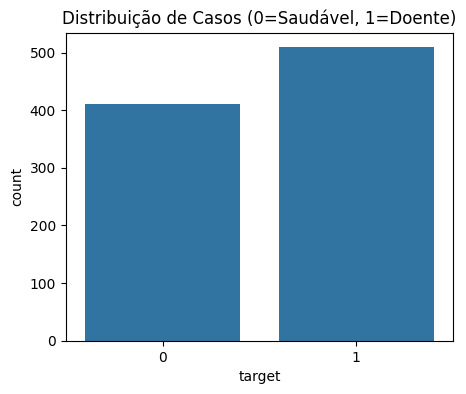

In [ ]:
# Visualizar distribuição do target
plt.figure(figsize=(5,4))
sns.countplot(x='target', data=df)
plt.title('Distribuição de Casos (0=Saudável, 1=Doente)')
plt.show()

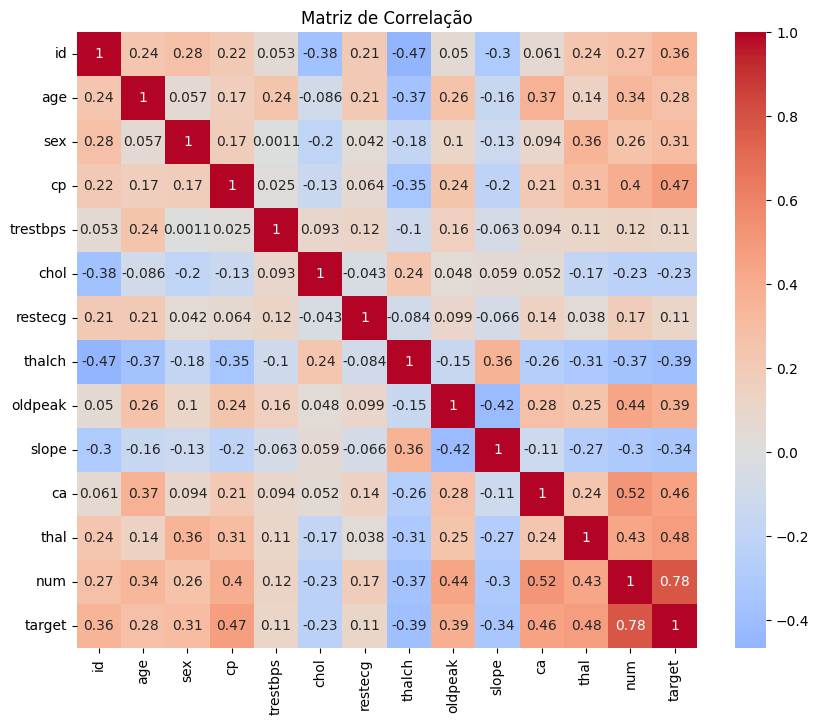

In [ ]:
# Correlação inicial entre colunas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'target' in numeric_cols:
    plt.figure(figsize=(10,8))
    sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', center=0)
    plt.title('Matriz de Correlação')
    plt.show()

### KNNImputer OU MÉDIA EM COLUNAS NUMÉRICAS REMANESCENTES


### Tratamento de dados faltantes

In [ ]:
if len(cols_with_na) > 0:
    print("Aplicando imputação nas colunas restantes:", cols_with_na)

    # Filtrar apenas colunas numéricas
    numeric_cols_to_impute = [c for c in cols_with_na if pd.api.types.is_numeric_dtype(df[c])]
    if numeric_cols_to_impute:
        print("Aplicando KNNImputer para colunas numéricas:", numeric_cols_to_impute)
        imputer = KNNImputer(n_neighbors=3)
        df[numeric_cols_to_impute] = imputer.fit_transform(df[numeric_cols_to_impute])

    # Se ainda houver colunas categóricas com NA, poderíamos removê-las ou preencher
    cat_na_cols = [c for c in cols_with_na if c not in numeric_cols_to_impute]
    if cat_na_cols:
        print("Ainda restam colunas categóricas com NA:", cat_na_cols)
        # Ex: remover
        # df.drop(columns=cat_na_cols, inplace=True)

Aplicando imputação nas colunas restantes: ['trestbps', 'chol', 'restecg', 'thalch', 'oldpeak', 'slope', 'ca', 'thal']
Aplicando KNNImputer para colunas numéricas: ['trestbps', 'chol', 'restecg', 'thalch', 'oldpeak', 'slope', 'ca', 'thal']


In [ ]:
# Conferir se agora não há mais NaN
final_na_cols = [c for c in df.columns if df[c].isnull().sum() > 0]
print("\nApós imputações, colunas que ainda têm NaN:", final_na_cols if final_na_cols else "Nenhuma")


Após imputações, colunas que ainda têm NaN: Nenhuma


## SELECIONANDO FEATURES, DIVISÃO E BALANCEAMENTO

In [ ]:
final_features = ['age', 'sex', 'cp', 'thalch',
 'oldpeak', 'ca', 'trestbps', 'chol', 'restecg', 'slope']
final_features = [f for f in final_features if f in df.columns]
print("\nFeatures finais selecionadas:", final_features)

X = df[final_features].copy()
y = df['target'].copy()


Features finais selecionadas: ['age', 'sex', 'cp', 'thalch', 'oldpeak', 'ca', 'trestbps', 'chol', 'restecg', 'slope']


In [ ]:
pos_rate = y.mean()
print(f"Proporção de doentes (target=1): {pos_rate:.2%}")

Proporção de doentes (target=1): 55.33%


In [ ]:
#SPLIT 1 TREINO/TESTE
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("\nTamanhos de treino/teste:", X_train.shape, X_test.shape)


Tamanhos de treino/teste: (736, 10) (184, 10)


##NORMALIZAÇÃO E VALIDAÇÃO CRUZADA + GRIDSEARCH

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [ ]:
from sklearn.svm import SVC

svm_base = SVC(probability=True, random_state=42)

# Exemplo de hiperparâmetros
param_grid = {
    'C': [0.01, 0.1, 0.15, 0.5, 1, 10, 5, 15, 20],
    'kernel': ['linear','rbf'],
    'gamma': ['scale','auto']
}

grid_search = GridSearchCV(
    svm_base,
    param_grid,
    cv=5,
    scoring='accuracy'
)
grid_search.fit(X_train_scaled, y_train)

best_svm = grid_search.best_estimator_

print("\nMelhores parâmetros SVM:", grid_search.best_params_)
print("Melhor acurácia (Val.Cruzada):", grid_search.best_score_)


Melhores parâmetros SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Melhor acurácia (Val.Cruzada): 0.8206747563890422


## AVALIAÇÃO FINAL


=== MÉTRICAS NO TESTE (SVM) ===
 Acurácia : 83.15%
 Precisão : 81.42%
 Recall   : 90.20%
 F1-Score : 85.58%

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.86      0.74      0.80        82
           1       0.81      0.90      0.86       102

    accuracy                           0.83       184
   macro avg       0.84      0.82      0.83       184
weighted avg       0.83      0.83      0.83       184



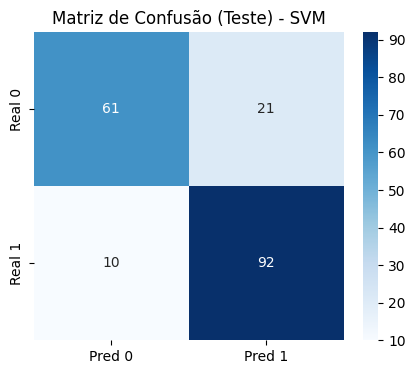

In [ ]:
y_pred = best_svm.predict(X_test_scaled)
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)

print(f"\n=== MÉTRICAS NO TESTE (SVM) ===")
print(f" Acurácia : {acc:.2%}")
print(f" Precisão : {prec:.2%}")
print(f" Recall   : {rec:.2%}")
print(f" F1-Score : {f1:.2%}")

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0','Pred 1'],
            yticklabels=['Real 0','Real 1'])
plt.title("Matriz de Confusão (Teste) - SVM")
plt.show()


=== Importância das Features (SVM com Kernel não Linear) ===
Usando Permutation Importance...


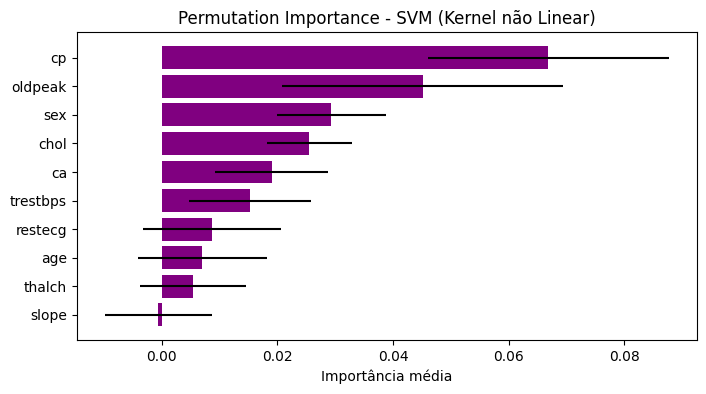


Permutation Importances:
1) cp = 0.0668 ± 0.0208
2) oldpeak = 0.0451 ± 0.0243
3) sex = 0.0293 ± 0.0095
4) chol = 0.0255 ± 0.0073
5) ca = 0.0190 ± 0.0098
6) trestbps = 0.0152 ± 0.0105
7) restecg = 0.0087 ± 0.0120
8) age = 0.0071 ± 0.0112
9) thalch = 0.0054 ± 0.0091
10) slope = -0.0005 ± 0.0092


In [ ]:
from sklearn.inspection import permutation_importance

if best_svm.kernel == 'linear':
    print("\n=== Importância das Features (SVM Linear) ===")
    # SVC para classific. binária -> shape (1, n_features)
    coefs = best_svm.coef_[0]
    abs_coefs = np.abs(coefs)
    feat_importance_df = pd.DataFrame({
        'Feature': final_features,
        'Coef': coefs,
        'AbsCoef': abs_coefs
    }).sort_values('AbsCoef', ascending=False)

    plt.figure(figsize=(8,4))
    sns.barplot(x='AbsCoef', y='Feature', data=feat_importance_df, palette='viridis')
    plt.title("Importância (|coef|) - SVM Linear")
    plt.show()

    print("\nCoeficientes do SVM Linear, ordenados por influência:")
    display(feat_importance_df[['Feature','Coef']])

else:
    print("\n=== Importância das Features (SVM com Kernel não Linear) ===")
    print("Usando Permutation Importance...")

    # Precisamos de X_test_scaled e y_test
    # (Já os temos do passo anterior)
    result = permutation_importance(
        best_svm,
        X_test_scaled,
        y_test,
        scoring='accuracy',
        n_repeats=10,
        random_state=42
    )
    imp_means = result.importances_mean
    imp_stds = result.importances_std

    # Ordenar do mais importante p/ menos
    indices = np.argsort(imp_means)[::-1]
    sorted_feats = [final_features[i] for i in indices]
    sorted_imp = imp_means[indices]
    sorted_stds = imp_stds[indices]

    plt.figure(figsize=(8,4))
    plt.barh(sorted_feats[::-1], sorted_imp[::-1], xerr=sorted_stds[::-1], color='purple')
    plt.title("Permutation Importance - SVM (Kernel não Linear)")
    plt.xlabel("Importância média")
    plt.show()

    print("\nPermutation Importances:")
    for i, idx in enumerate(indices):
        print(f"{i+1}) {final_features[idx]} = {sorted_imp[i]:.4f} ± {sorted_stds[i]:.4f}")